In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [1]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model


# Running LSTM Hourly with 1 Basin
This will be based on Example 01, where we train on just 1 basin. This one basin is Fontenelle, WY just to mix things up a little. 
## Training the model
Reading forcings would be done with the csv files instead of the nc files, which I couldn't figure out to do. The data should be the same, just gets processed slower. This means some settings/variable names in the configuration file changes as well. 

In [1]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    print("GPU")
    start_run(config_file=Path("basin_cudalstmHourly.yml"))

# fall back to CPU-only mode
else:
    print("CPU")
    start_run(config_file=Path("basin_cudalstmHourly.yml"), gpu=-1)

NameError: name 'torch' is not defined

## Evaluating Model

In [11]:
run_dir = Path("runs/testCudalstmHourly_run_2707_185328")
eval_run(run_dir=run_dir, period="test")

2024-07-28 14:06:39,320: Using the model weights from runs/testCudalstmHourly_run_2707_185328/model_epoch050.pt
# Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-28 14:06:39,324: ## Warning: Hourly nldas_hourly NetCDF file not found. Falling back to slower csv files.
Metrics for 1h are calculated over last 1 elements only. Ignoring 23 predictions per sequence.
# Evaluation: 100%|██████████| 1/1 [00:22<00:00, 22.10s/it]
2024-07-28 14:07:01,438: Stored metrics at runs/testCudalstmHourly_run_2707_185328/test/model_epoch050/test_metrics.csv
2024-07-28 14:07:01,446: Stored results at runs/testCudalstmHourly_run_2707_185328/test/model_epoch050/test_results.p


## Load and Inspect

In [12]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp: # we only have 25 epoch max
    results = pickle.load(fp)
    
results.keys()

dict_keys(['09210500'])

In [35]:
results["09210500"]["1h"]["xr"].sel(date=slice("10-1995", None))

<xarray.Dataset>
Dimensions:         (date: 35064, time_step: 24)
Coordinates:
  * date            (date) datetime64[ns] 1995-10-01 ... 1999-09-30T23:00:00
  * time_step       (time_step) int64 -23 -22 -21 -20 -19 -18 ... -4 -3 -2 -1 0
Data variables:
    QObs(mm/h)_obs  (date, time_step) float32 0.008808 0.008808 ... 0.01218
    QObs(mm/h)_sim  (date, time_step) float32 0.01291 0.01293 ... 0.008896

Now plotting it.

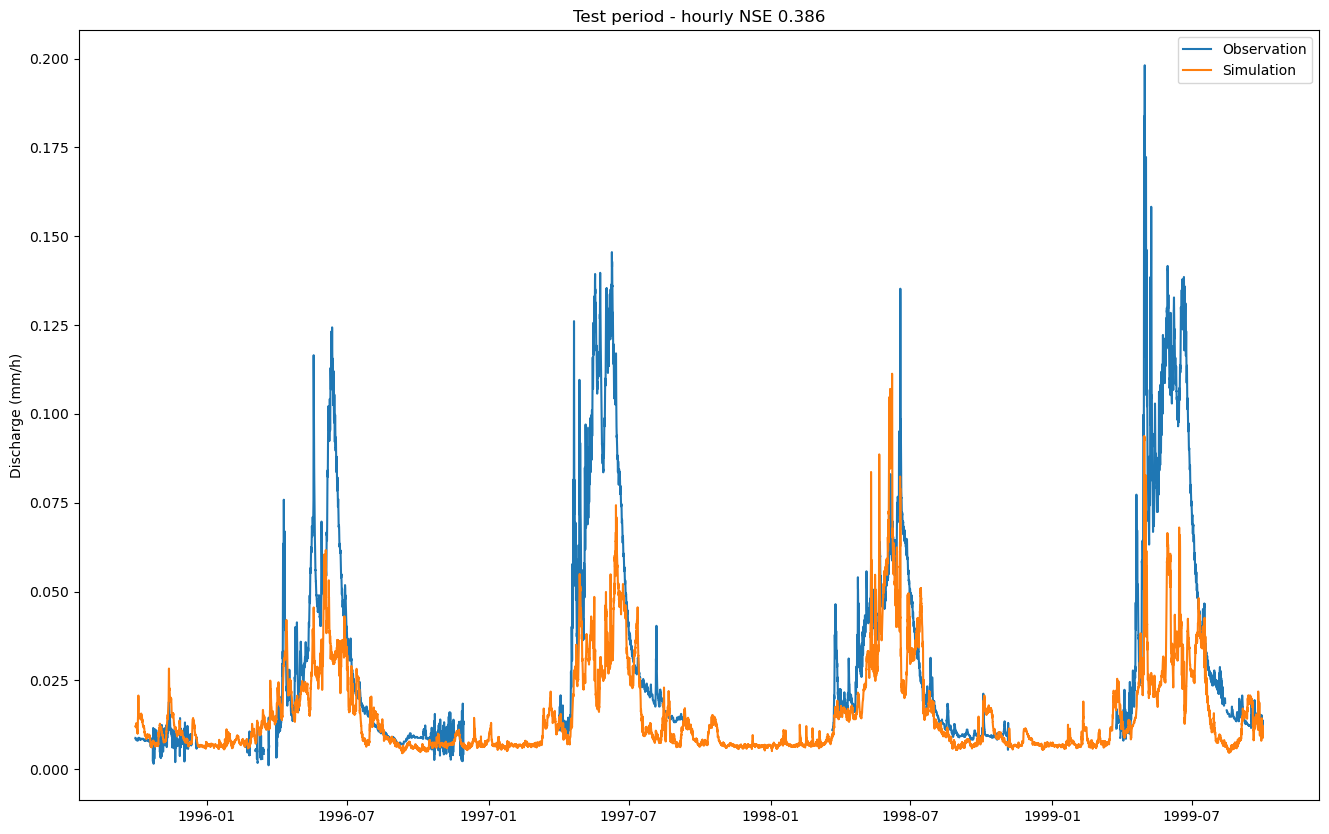

In [77]:
# extract a date slice of observations and simulations
hourly_xr = results["09210500"]["1h"]["xr"].sel(date=slice("10-1995", None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select 1 hour of each day and then stack
# the two dimensions into one consecutive datetime dimension. (this was done since validation is only 1hr,
# this was the only way to get correct datetime values)
hourly_xr = hourly_xr.isel(time_step=slice(-1, None)).stack(datetime=['date', 'time_step'])
hourly_xr['Datetime'] = hourly_xr.coords['date'] + hourly_xr.coords['time_step']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(hourly_xr['Datetime'], hourly_xr["QObs(mm/h)_obs"], label="Observation")
ax.plot(hourly_xr['Datetime'], hourly_xr["QObs(mm/h)_sim"], label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['09210500']['1h']['NSE']:.3f}")
_ = ax.legend()

# Running Hybrid Model on 2 Basin

This will be based on Example 01, where we train on just 1 basin. This will be daily.

## Training Hybrid

Custom normalization documentation is here: https://github.com/mines-ciroh/neuralhydrology/blob/master/docs/source/usage/config.rst

In [3]:

# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    print("GPU")
    start_run(config_file=Path("basin_hybrid.yml"))

# fall back to CPU-only mode
else:
    print("CPU")
    start_run(config_file=Path("basin_hybrid.yml"), gpu=-1)

CPU
2024-09-12 15:18:38,607: Logging to /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testHybrid_run_1209_151838/output.log initialized.
2024-09-12 15:18:38,609: ### Folder structure created at /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testHybrid_run_1209_151838
2024-09-12 15:18:38,610: ### Run configurations for testHybrid_run
2024-09-12 15:18:38,611: experiment_name: testHybrid_run
2024-09-12 15:18:38,612: train_basin_file: 2_basin.txt
2024-09-12 15:18:38,613: validation_basin_file: 2_basin.txt
2024-09-12 15:18:38,614: test_basin_file: 2_basin.txt
2024-09-12 15:18:38,615: train_start_date: 1999-10-01 00:00:00
2024-09-12 15:18:38,615: train_end_date: 2008-09-30 00:00:00
2024-09-12 15:18:38,616: validation_start_date: 1980-10-01 00:00:00
2024-09-12 15:18:38,61

Great! this is trained. What happened was the error keeps getting stuck on the x_conceptual input where the `x_conceptual[:,:,2]` and/or `x_conceptual[:,:,3]` do not exist. So the problem was with what files are being in-puted. We know that `x_conceptual[:,:,2]` is `tmin` and the other `tmax`, and `x_conceptual[:,:,0]` is `precip`. But no idea what `x_conceptual[:,:,1]` is, so I just put in a random one -- `swe`. It probably ins't super correct but I didn't spend time looking into what that value is supposed to be. 

## Evaluating Hybrid Model

Evaluate the trained model on the test set. 

In [21]:
run_dir = Path("runs/testHybrid_run_2207_222746")
eval_run(run_dir=run_dir, period="test")

2024-07-26 20:17:48,055: Using the model weights from runs/testHybrid_run_2207_222746/model_epoch050.pt
# Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
2024-07-26 20:17:50,469: Stored metrics at runs/testHybrid_run_2207_222746/test/model_epoch050/test_metrics.csv
2024-07-26 20:17:50,476: Stored results at runs/testHybrid_run_2207_222746/test/model_epoch050/test_results.p


## Load n Inspect Hybrid Model Prediction

Load the results, double check it is the right basin. 

In [65]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp: # we only have 25 epoch max
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

In [66]:
results['01022500']['1D']['xr']

<xarray.Dataset> Size: 58kB
Dimensions:         (date: 3652, time_step: 1)
Coordinates:
  * date            (date) datetime64[ns] 29kB 1989-10-01 ... 1999-09-30
  * time_step       (time_step) int64 8B 0
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 15kB 0.6203 0.5537 ... 0.9992
    QObs(mm/d)_sim  (date, time_step) float32 15kB 0.05974 0.05814 ... 0.1898

Looks consistent. Now plot it.

Text(0.5, 1.0, 'Test period - NSE 0.653')

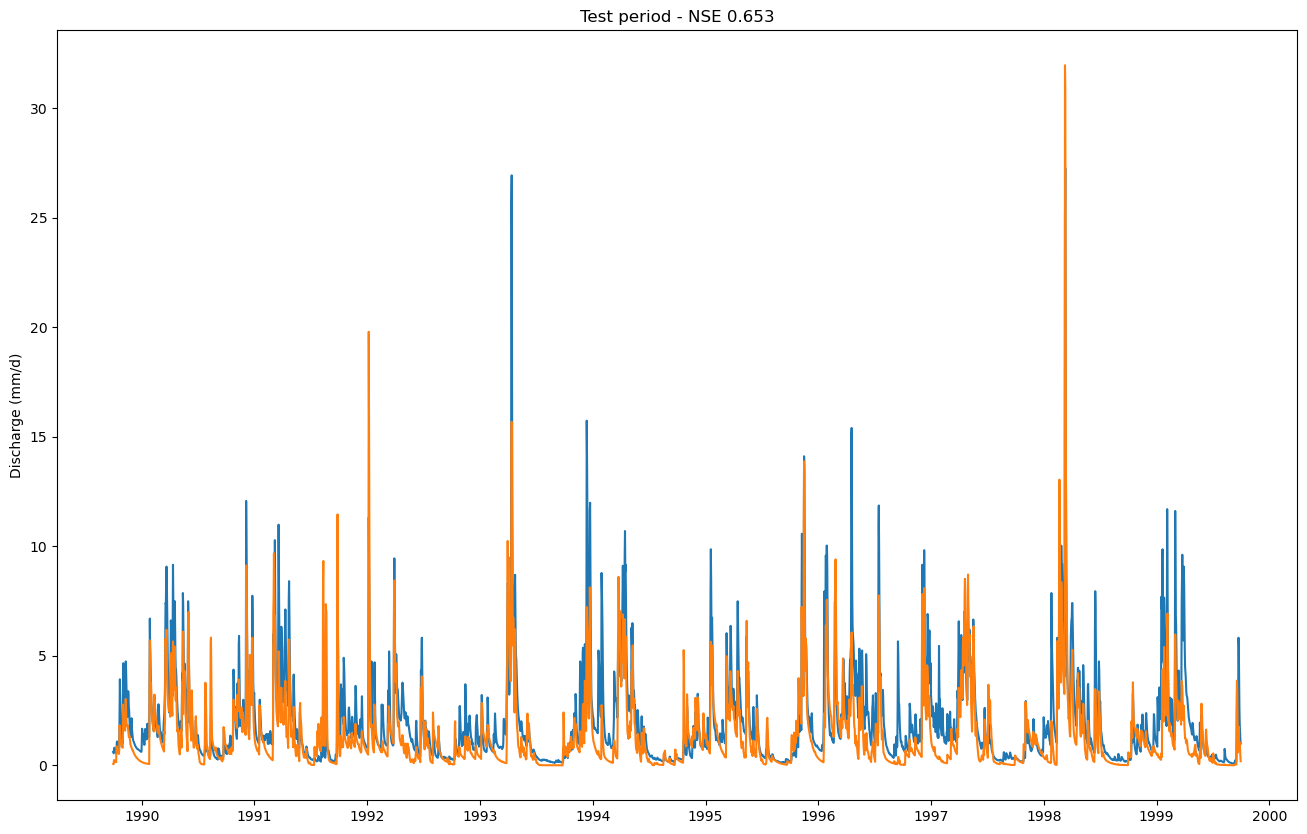

In [67]:
# extract observations and simulations
qobs = results['01022500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['01022500']['1D']['xr']['QObs(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01022500']['1D']['NSE']:.3f}")

Note that this is not as good as the default LSTM model (NSE = 0.788), with NSE = 0.653 with the 2nd variable being `srad` and `warmup_period = 30`, but this might be due to choosing a randome 2nd forcing file. 

This is further evidenced by the fact that when I changed the 2nd variable to `SWE` with a `warmup_period = 30`, we have NSE = 0.691.

Now examine other metrics:

In [60]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

NSE: 0.691
MSE: 1.523
RMSE: 1.234
KGE: 0.732
Alpha-NSE: 1.149
Beta-KGE: 1.192
Beta-NSE: 0.174
Pearson-r: 0.888
FHV: 13.428
FMS: 9.237
FLV: 37.905
Peak-Timing: 0.391
Peak-MAPE: 34.462


/Users/ziyu/miniconda3/envs/dCFE_env/lib/python3.12/site-packages/neuralhydrology/datautils/utils.py:327: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/ziyu/miniconda3/envs/dCFE_env/lib/python3.12/site-packages/neuralhydrology/datautils/utils.py:368: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


Hourly is not possible with hybridmodel-shm combo without modification, the nldas_hourly forcings file do not have tmin or tmax, only "temperature", which I believe is the average temperature. 

# Running Hybrid SHM 2-Basins Hourly

## Training

In [2]:

# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    print("GPU")
    start_run(config_file=Path("basin_hybridHourly.yml"))

# fall back to CPU-only mode
else:
    print("CPU")
    start_run(config_file=Path("basin_hybridHourly.yml"), gpu=-1)

CPU
2024-09-30 12:58:30,950: Logging to /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testHybrid_run_3009_125830/output.log initialized.
2024-09-30 12:58:30,951: ### Folder structure created at /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testHybrid_run_3009_125830
2024-09-30 12:58:30,951: ### Run configurations for testHybrid_run
2024-09-30 12:58:30,952: experiment_name: testHybrid_run
2024-09-30 12:58:30,952: train_basin_file: 1_basin.txt
2024-09-30 12:58:30,953: validation_basin_file: 1_basin.txt
2024-09-30 12:58:30,954: test_basin_file: 1_basin.txt
2024-09-30 12:58:30,954: train_start_date: 1999-10-01 00:00:00
2024-09-30 12:58:30,955: train_end_date: 2008-09-30 00:00:00
2024-09-30 12:58:30,955: validation_start_date: 2008-10-01 00:00:00
2024-09-30 12:58:30,95

# Testing dCFE (updated 9/29/2024)

The `dcfe.py` file is going to function somewhat like `shm.py`, so it could be implemented using `hybrid_model`. The first goal is to get it to train correctly on just 1 basin with the correct PET info,

In [4]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    print("GPU")
    start_run(config_file=Path("basin_dCFEwPET.yml"))

# fall back to CPU-onl y mode
else:
    print("CPU")
    start_run(config_file=Path("basin_dCFEwPET.yml"), gpu=-1)

CPU
2024-09-29 16:05:13,677: Logging to /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testdCFEpet_run_2909_160513/output.log initialized.
2024-09-29 16:05:13,678: ### Folder structure created at /Users/ziyu/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Documents/College/ResearchStuff/NextGen/neuralhydrology/examples/07-DifferentialCFE-Model/runs/testdCFEpet_run_2909_160513
2024-09-29 16:05:13,678: ### Run configurations for testdCFEpet_run
2024-09-29 16:05:13,678: experiment_name: testdCFEpet_run
2024-09-29 16:05:13,679: train_basin_file: 1_basin.txt
2024-09-29 16:05:13,679: validation_basin_file: 1_basin.txt
2024-09-29 16:05:13,679: test_basin_file: 1_basin.txt
2024-09-29 16:05:13,681: train_start_date: 2000-10-01 00:00:00
2024-09-29 16:05:13,681: train_end_date: 2013-09-30 00:00:00
2024-09-29 16:05:13,682: validation_start_date: 1980-10-01 00:00:00
2024-09-29 16:05:1

## Evaluating the Model

In [5]:
run_dir = Path("runs/testdCFEpet_run_2909_160513")
eval_run(run_dir=run_dir, period="test")

2024-09-29 16:33:11,200: Using the model weights from runs/testdCFEpet_run_2909_160513/model_epoch005.pt
# Evaluation: 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]
2024-09-29 16:33:19,725: Stored metrics at runs/testdCFEpet_run_2909_160513/test/model_epoch005/test_metrics.csv
2024-09-29 16:33:19,727: Stored results at runs/testdCFEpet_run_2909_160513/test/model_epoch005/test_results.p


## Visualization Prediction

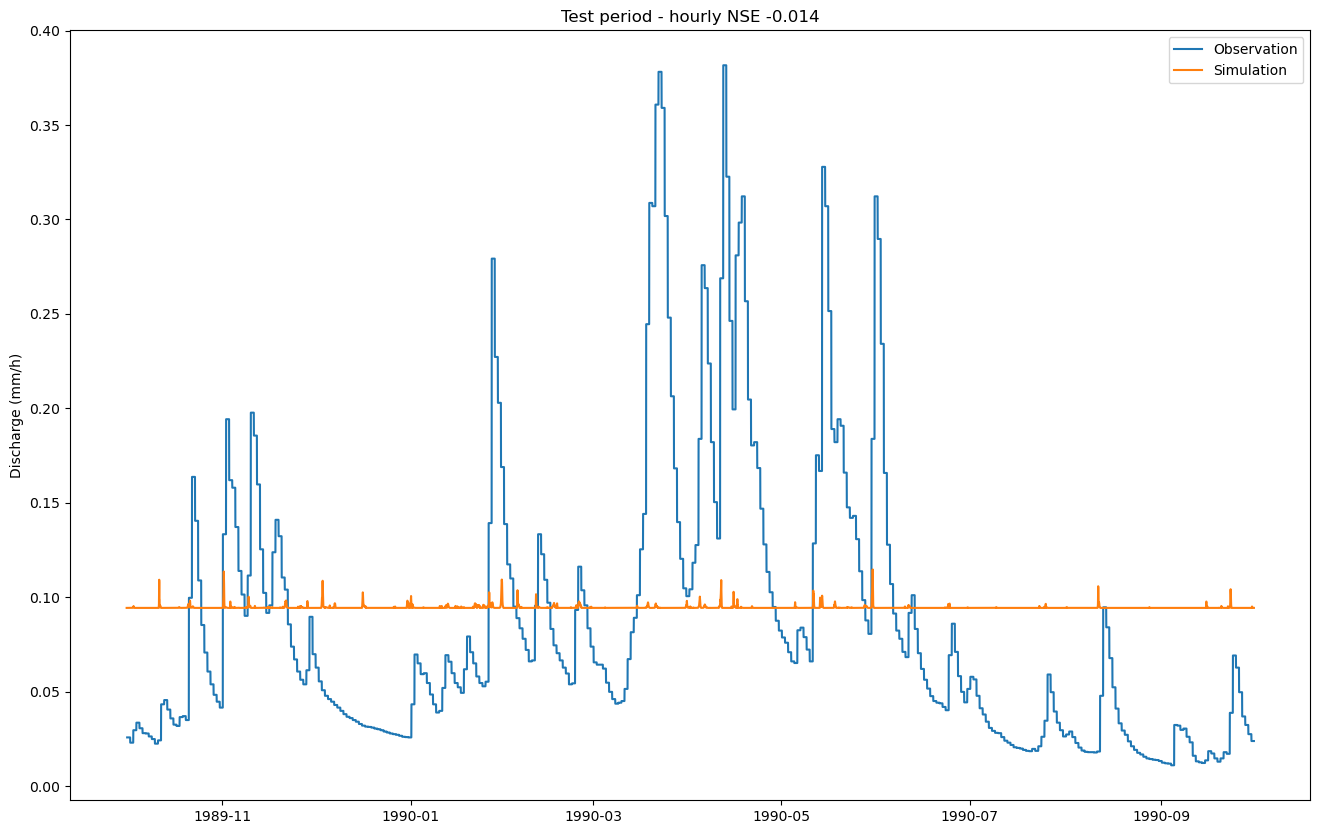

In [6]:
with open(run_dir / "test" / "model_epoch005" / "test_results.p", "rb") as fp: # we only have 25 epoch max
    results = pickle.load(fp)

# extract a date slice of observations and simulations
hourly_xr = results["01022500"]["1h"]["xr"].sel(date=slice("10-1989", None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select 1 hour of each day and then stack
# the two dimensions into one consecutive datetime dimension. (this was done since validation is only 1hr,
# this was the only way to get correct datetime values)
hourly_xr = hourly_xr.isel(time_step=slice(-1, None)).stack(datetime=['date', 'time_step'])
hourly_xr['Datetime'] = hourly_xr.coords['date'] + hourly_xr.coords['time_step']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(hourly_xr['Datetime'], hourly_xr["QObs_CAMELS(mm/h)_obs"], label="Observation")
ax.plot(hourly_xr['Datetime'], hourly_xr["QObs_CAMELS(mm/h)_sim"], label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['01022500']['1h']['NSE']:.3f}")
_ = ax.legend()

In [13]:
results["01022500"]["1h"]["xr"].sel(date=slice("10-1989", None))

<xarray.Dataset> Size: 140kB
Dimensions:         (date: 8760, time_step: 1)
Coordinates:
  * date            (date) datetime64[ns] 70kB 1989-10-01 ... 1990-09-30T23:0...
  * time_step       (time_step) int64 8B 0
Data variables:
    QObs(mm/h)_obs  (date, time_step) float32 35kB nan nan ... 0.02324 0.02324
    QObs(mm/h)_sim  (date, time_step) float32 35kB 3.979 4.02 ... 3.968 3.978

(09/01) The plot above looks order of magnitude off. Not sure if it's because there's not enough training data (1 year only), or not enough epochs (2 epochs only), or I did some calculations incorrectly to aggregate simulated data, or something is wrong with the physics. Will be investigating this further. 

# Evaluating from Wendian
The process of training even just 2 epochs are taking too long, so this is just evaluating and examining performance of the model from runs on Wendian.
## Evaluating the Model

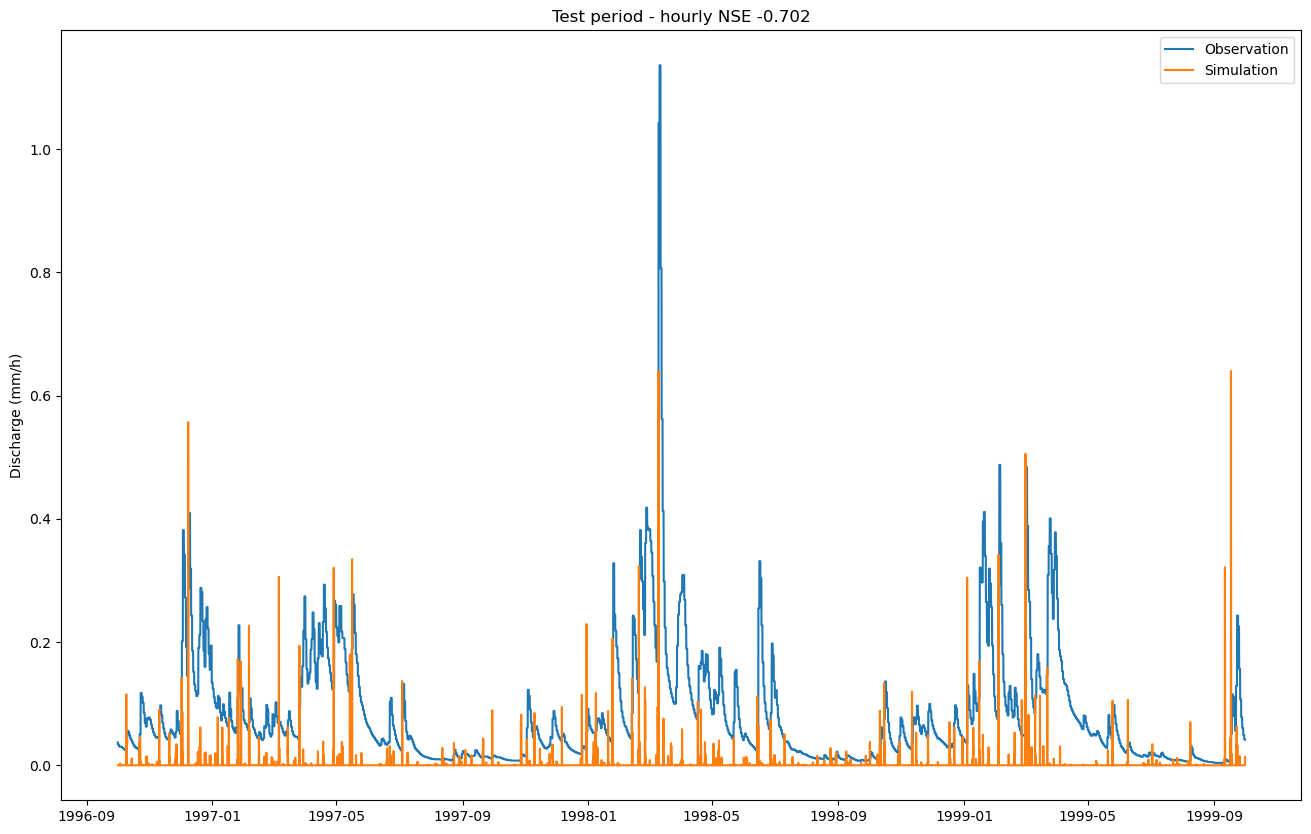

In [9]:
run_dir = Path("runs/testWarmup15yrdCFE_run_1709_141246")

with open(run_dir / "test" / "model_epoch005" / "test_results.p", "rb") as fp: # we only have 25 epoch max
    results = pickle.load(fp)

# extract a date slice of observations and simulations
hourly_xr = results["01022500"]["1h"]["xr"].sel(date=slice("10-1996", None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select 1 hour of each day and then stack
# the two dimensions into one consecutive datetime dimension. (this was done since validation is only 1hr,
# this was the only way to get correct datetime values)
hourly_xr = hourly_xr.isel(time_step=slice(-1, None)).stack(datetime=['date', 'time_step'])
hourly_xr['Datetime'] = hourly_xr.coords['date'] + hourly_xr.coords['time_step']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(hourly_xr['Datetime'], hourly_xr["QObs_CAMELS(mm/h)_obs"], label="Observation")
ax.plot(hourly_xr['Datetime'], hourly_xr["QObs_CAMELS(mm/h)_ßsim"], label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['01022500']['1h']['NSE']:.3f}")
_ = ax.legend()

In [8]:
hourly_xr

<xarray.Dataset> Size: 1MB
Dimensions:                (datetime: 26280)
Coordinates:
  * datetime               (datetime) object 210kB MultiIndex
  * date                   (datetime) datetime64[ns] 210kB 1996-10-01 ... 199...
  * time_step              (datetime) int64 210kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Data variables:
    QObs_CAMELS(mm/h)_obs  (datetime) float32 105kB 0.03712 0.03712 ... 0.04163
    QObs_CAMELS(mm/h)_sim  (datetime) float32 105kB 0.0 0.0 ... 0.01351 0.01354
    Datetime               (datetime) datetime64[ns] 210kB 1996-10-01 ... 199...